In [1]:
import uproot # for reading .root files
import pandas as pd # to store data as dataframea
import time # to measure time to analyse
import math # for mathematical functions such as square root
import numpy as np # # for numerical calculations such as histogramming
import matplotlib.pyplot as plt # for plotting
from matplotlib.ticker import MaxNLocator,AutoMinorLocator # for minor ticks;
from lmfit.models import PolynomialModel, GaussianModel # for the signal and background fits
import requests # for HTTP access
import aiohttp # HTTP client support

In [2]:
import uproot
# Define the path to the directory and the list of samples
tuple_path = "/project/etp1/dkoch/ATLASOpenData/GamGam/Data/"
samples_list = [
    'data15_periodD', 'data15_periodG', 'data16_periodA', 'data16_periodD', 'data16_periodG', 'data16_periodL',
    'data15_periodE', 'data15_periodH', 'data16_periodB', 'data16_periodE', 'data16_PeriodI',
    'data15_periodF', 'data15_periodJ', 'data16_periodC', 'data16_periodF', 'data16_periodK'
]


In [3]:
lumi = 10 # fb-1 # data_A,data_B,data_C,data_D
fraction = 1 # reduce this is you want the code to run quicker
#tuple_path = "Input/GamGam/Data/" # local 
tuple_path = "/project/etp1/dkoch/ATLASOpenData/GamGam/Data/"
#tuple_path = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/GamGam/Data/" # web address

In [4]:
def get_data_from_files():

    frames = [] # define empty list to hold data
    for val in samples_list: # loop over each file
        fileString = tuple_path+val+".root" # file name to open
        temp = read_file_new(fileString) # call the function read_file defined below
        frames.append(temp) # append dataframe returned from read_file to list of dataframes
    data = pd.concat(frames) # concatenate list of dataframes together into one dataframe
    
    return data # return dataframe

In [5]:
def calc_myy(photon_pt,photon_eta,photon_phi,photon_E):
    # first photon is [0], 2nd photon is [1] etc
    px_0 = photon_pt[0]*math.cos(photon_phi[0]) # x-component of photon[0] momentum
    py_0 = photon_pt[0]*math.sin(photon_phi[0]) # y-component of photon[0] momentum
    pz_0 = photon_pt[0]*math.sinh(photon_eta[0]) # z-component of photon[0] momentum
    px_1 = photon_pt[1]*math.cos(photon_phi[1]) # x-component of photon[1] momentum
    py_1 = photon_pt[1]*math.sin(photon_phi[1]) # y-component of photon[1] momentum
    pz_1 = photon_pt[1]*math.sinh(photon_eta[1]) # z-component of photon[1] momentum
    sumpx = px_0 + px_1 # x-component of diphoton momentum
    sumpy = py_0 + py_1 # y-component of diphoton momentum
    sumpz = pz_0 + pz_1 # z-component of diphoton momentum 
    sump = math.sqrt(sumpx**2 + sumpy**2 + sumpz**2) # magnitude of diphoton momentum 
    sumE = photon_E[0] + photon_E[1] # energy of diphoton system
    m2 = sumE**2 - sump**2
    if m2>0.:
        m = m2**0.5
    else:
        print('calc_myy error neg mass**2', m2)
        m = 0.
    return m 

In [6]:
def cut_photon_reconstruction(photon_isTightID):
    return photon_isTightID[0]==True and photon_isTightID[1]==True

def cut_photon_pt(photon_pt):
    return photon_pt[0]>40 and photon_pt[1]>30



def cut_photon_eta_transition(photon_eta):
    return (abs(photon_eta[0])>1.52 or abs(photon_eta[0])<1.37) and (abs(photon_eta[1])>1.52 or abs(photon_eta[1])<1.37)

def cut_n_photon(photon_n):
    return photon_n>=2


In [7]:
#pname = '/project/etp1/dkoch/ATLASOpenData/ntuples-data-samples/data15_allyear.root'
#tree = uproot.open(pname+':analysis')
def read_file_new(path):
    start = time.time() # start the clock
    print("Processing: "+path) # print which sample is being processed
    data_all = pd.DataFrame() # define empty pandas DataFrame to hold all data for this sample
    tree = uproot.open(path + ":analysis")
    numevents = tree.num_entries # number of events
    for data in tree.iterate(["photon_n","photon_pt","photon_eta","photon_phi","photon_e",
                            "photon_isTightID","photon_ptcone20"], # add more variables here if you want to use them
                           library="pd", # choose output type as pandas DataFrame
                           entry_stop=numevents*fraction): # process up to numevents*fraction

        nIn = len(data.index) # number of events in this batch
        print("before cut ",len(data.index))
       

        # Cut on photon reconstruction quality using the function cut_photon_reconstruction defined above
        data = data[ np.vectorize(cut_photon_reconstruction)(data.photon_isTightID)]
        
        print("istight-cut ",len(data.index))
        
        # Cut on transverse momentum of the photons using the function cut_photon_pt defined above
        data = data[ np.vectorize(cut_photon_pt)(data.photon_pt)]
        print("pt-cut ",len(data.index))
        
   
        
        # Cut on pseudorapidity inside barrel/end-cap transition region using the function cut_photon_eta_transition
        data = data[ np.vectorize(cut_photon_eta_transition)(data.photon_eta)]
        print("eta-cut ",len(data.index))
        
        # Calculate reconstructed diphoton invariant mass using the function calc_myy defined above
        data['myy'] = np.vectorize(calc_myy)(data.photon_pt,data.photon_eta,data.photon_phi,data.photon_e)
        
        # dataframe contents can be printed at any stage like this
        #print(data)

        # dataframe column can be printed at any stage like this
        #print(data['photon_pt'])

        # multiple dataframe columns can be printed at any stage like this
        #print(data[['photon_pt','photon_eta']])

        nOut = len(data.index) # number of events passing cuts in this batch
        data_all = pd.concat([data_all, data], ignore_index=True)
        elapsed = time.time() - start # time taken to process
        print("\t nIn: "+str(nIn)+",\t nOut: \t"+str(nOut)+"\t in "+str(round(elapsed,1))+"s") # events before and after
    
    return data_all # return dataframe containing events passing all cuts

In [8]:
start = time.time() # time at start of whole processing
data = get_data_from_files() # process all files
elapsed = time.time() - start # time after whole processing
print("Time taken: "+str(round(elapsed,1))+"s") # print total time taken to process every file

Processing: /project/etp1/dkoch/ATLASOpenData/GamGam/Data/data15_periodD.root
before cut  11371
istight-cut  1103
pt-cut  512
eta-cut  508
	 nIn: 11371,	 nOut: 	508	 in 1.2s
Processing: /project/etp1/dkoch/ATLASOpenData/GamGam/Data/data15_periodG.root
before cut  164583
istight-cut  16422
pt-cut  8018
eta-cut  7960
	 nIn: 164583,	 nOut: 	7960	 in 1.5s
Processing: /project/etp1/dkoch/ATLASOpenData/GamGam/Data/data16_periodA.root
before cut  108353
istight-cut  10070
pt-cut  5630
eta-cut  5592
calc_myy error neg mass**2 -0.0010712819930631667
calc_myy error neg mass**2 -0.0026543323328951374
	 nIn: 108353,	 nOut: 	5592	 in 1.1s
Processing: /project/etp1/dkoch/ATLASOpenData/GamGam/Data/data16_periodD.root
before cut  588911
istight-cut  57411
pt-cut  31509
eta-cut  31330
calc_myy error neg mass**2 -0.006799040318583138
calc_myy error neg mass**2 -0.07333811896387488
calc_myy error neg mass**2 -0.005610572945442982
	 nIn: 588911,	 nOut: 	31330	 in 5.3s
Processing: /project/etp1/dkoch/ATLAS

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



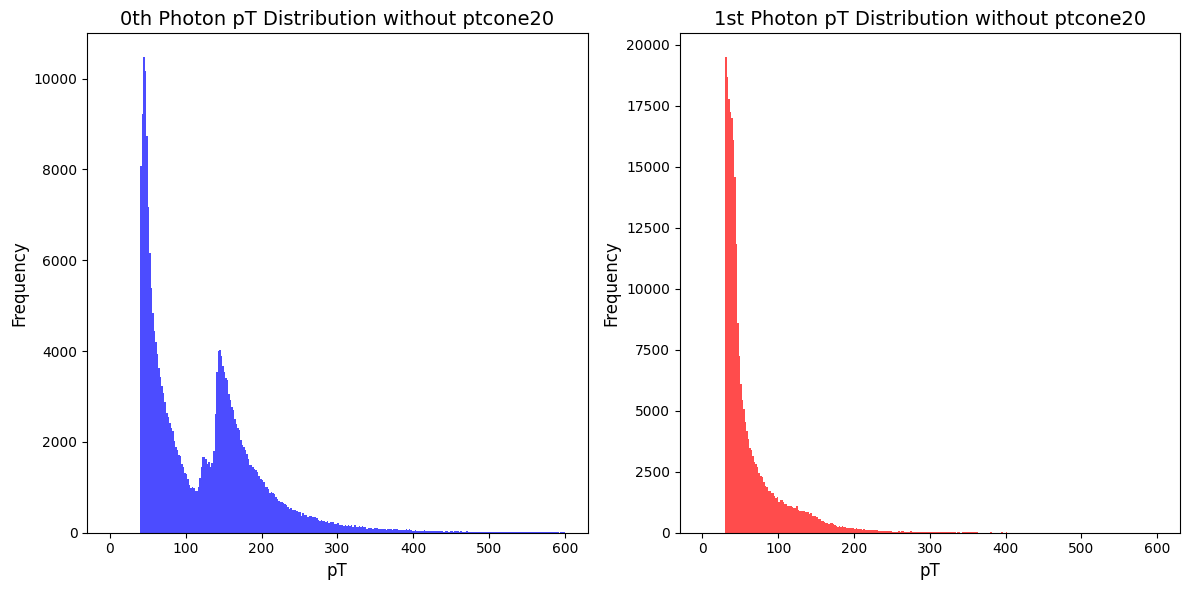

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'data' is your original DataFrame with 'photon_pt' as a column of lists
# Example DataFrame creation for context
# data = pd.DataFrame({'photon_pt': [[1.0, 2.0, 3.0, 4.0, ...], [5.0, 6.0, ...], ...]})

import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'data' is your original DataFrame with 'photon_pt' as a column of lists
# Example DataFrame creation for context
# data = pd.DataFrame({'photon_pt': [[1.0, 2.0, 3.0, 4.0, ...], [5.0, 6.0, ...], ...]})

# Convert the lists in the 'photon_pt' column into a DataFrame

photon_pt_df = pd.DataFrame(data['photon_pt'].tolist())

# Use pandas' indexing to get the 0th and 1st photon pt columns efficiently
photon_pt0 = photon_pt_df.iloc[:, 0].dropna()  # 0th photon properties
photon_pt1 = photon_pt_df.iloc[:, 1].dropna()  # 1st photon properties

# Display the results
print("0th Photon Properties:", photon_pt0.tolist())
print("1st Photon Properties:", photon_pt1.tolist())

# Plot histograms
plt.figure(figsize=(12, 6))

# Histogram for the 0th photon
plt.subplot(1, 2, 1)
plt.hist(photon_pt0, bins=300, range=(0, 600), color='b', alpha=0.7)
plt.title('0th Photon pT Distribution without ptcone20', fontsize=14)
plt.xlabel('pT', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Histogram for the 1st photon
plt.subplot(1, 2, 2)
plt.hist(photon_pt1, bins=300, range=(0, 600), color='r', alpha=0.7)
plt.title('1st Photon pT Distribution without ptcone20', fontsize=14)
plt.xlabel('pT', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()



0th Photon Properties: 0         1.693584
1         0.716575
2        -0.648634
3        -0.612345
4         1.848486
            ...   
258185    1.741476
258186    0.050998
258187   -2.303607
258188   -2.050013
258189    2.112383
Name: 0, Length: 258190, dtype: float64
1st Photon Properties: 0         1.159767
1         0.481084
2        -1.583985
3        -0.781752
4         1.767089
            ...   
258185   -0.989472
258186   -0.244908
258187   -1.088661
258188    1.303149
258189    2.168397
Name: 1, Length: 258190, dtype: float64


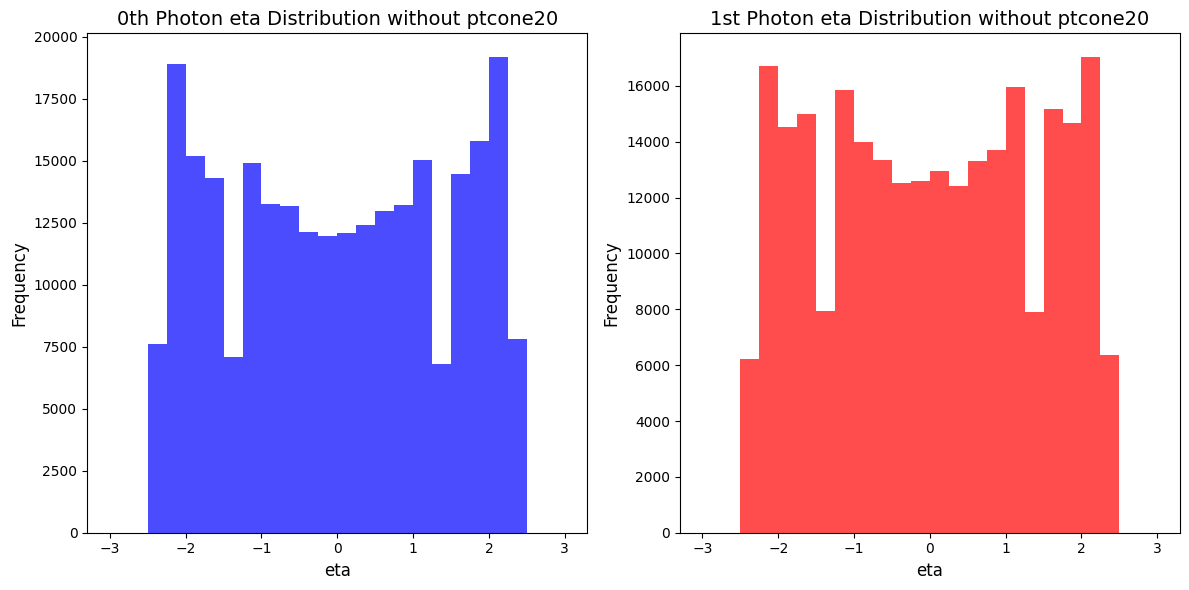

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import awkward as ak

# Assuming 'data' is your original DataFrame with 'photon_pt' as an Awkward Array

# Extracting the 0th and 1st photon properties directly during the list conversion
photon_pt_df = pd.DataFrame(data['photon_eta'].tolist())

# Use pandas' indexing to get the 0th and 1st photon pt columns efficiently
photon_pt0 = photon_pt_df.iloc[:, 0].dropna()  # 0th photon properties
photon_pt1 = photon_pt_df.iloc[:, 1].dropna()  # 1st photon properties


# Display the results
print("0th Photon Properties:", photon_pt0)
print("1st Photon Properties:", photon_pt1)

# You can also plot histograms for the 0th and 1st photon properties
plt.figure(figsize=(12, 6))

# Histogram for the 0th photon
plt.subplot(1, 2, 1)
plt.hist(photon_pt0, bins=24,range = (-3,3) ,color='b', alpha=0.7)
plt.title('0th Photon eta Distribution without ptcone20', fontsize=14)
plt.xlabel('eta', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Histogram for the 1st photon
plt.subplot(1, 2, 2)
plt.hist(photon_pt1, bins=24, range = (-3,3), color='r', alpha=0.7)
plt.title('1st Photon eta Distribution without ptcone20', fontsize=14)
plt.xlabel('eta', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()


0th Photon Properties: 0          0.000000
1          0.000000
2          3.446806
3          0.000000
4          0.000000
            ...    
258185    21.466467
258186     0.000000
258187     1.348211
258188     6.419190
258189     0.000000
Name: 0, Length: 258190, dtype: float64
1st Photon Properties: 0          0.000000
1          0.000000
2          4.316482
3         12.028741
4         56.377583
            ...    
258185     0.000000
258186     0.000000
258187     0.000000
258188     0.000000
258189     3.968106
Name: 1, Length: 258190, dtype: float64


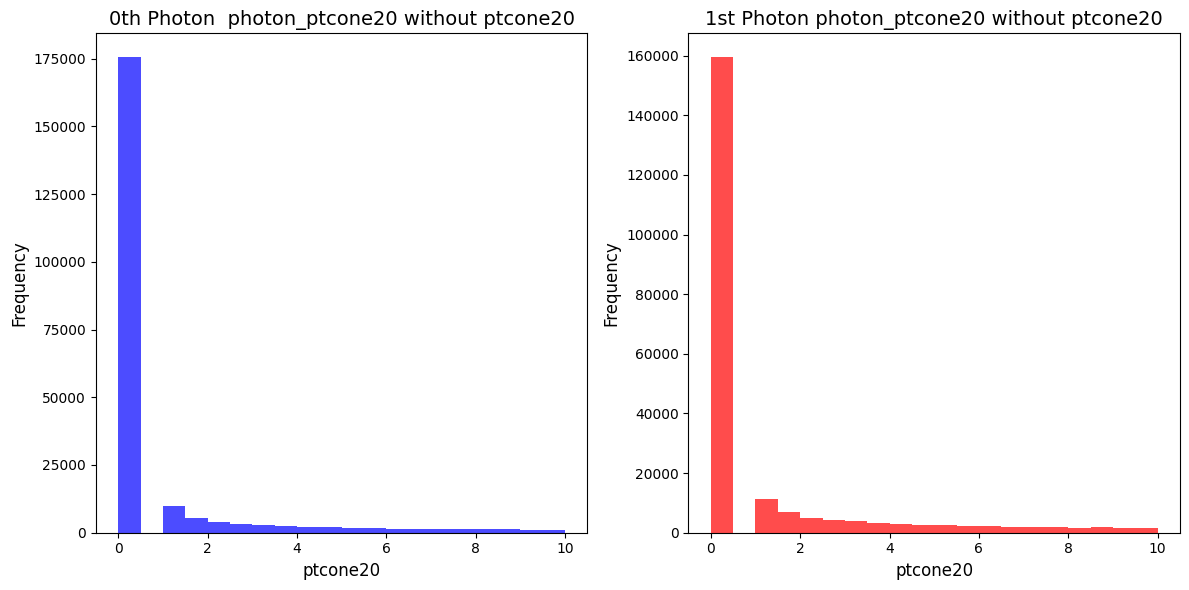

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import awkward as ak

# Assuming 'data' is your original DataFrame with 'photon_pt' as an Awkward Array

# Extract properties for the 0th and 1st photons
# Extracting the 0th and 1st photon properties directly during the list conversion
photon_pt_df = pd.DataFrame(data['photon_ptcone20'].tolist())

# Use pandas' indexing to get the 0th and 1st photon pt columns efficiently
photon_pt0 = photon_pt_df.iloc[:, 0].dropna()  # 0th photon properties
photon_pt1 = photon_pt_df.iloc[:, 1].dropna()  # 1st photon properties


# Display the results
print("0th Photon Properties:", photon_pt0)
print("1st Photon Properties:", photon_pt1)

# You can also plot histograms for the 0th and 1st photon properties
plt.figure(figsize=(12, 6))

# Histogram for the 0th photon
plt.subplot(1, 2, 1)
plt.hist(photon_pt0, bins=20,range = (0,10) ,color='b', alpha=0.7)
plt.title('0th Photon  photon_ptcone20 without ptcone20', fontsize=14)
plt.xlabel('ptcone20', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Histogram for the 1st photon
plt.subplot(1, 2, 2)
plt.hist(photon_pt1, bins=20, range = (0,10), color='r', alpha=0.7)
plt.title('1st Photon photon_ptcone20 without ptcone20', fontsize=14)
plt.xlabel('ptcone20', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()


0th Photon Properties: 0         True
1         True
2         True
3         True
4         True
          ... 
258185    True
258186    True
258187    True
258188    True
258189    True
Name: 0, Length: 258190, dtype: bool
1st Photon Properties: 0         True
1         True
2         True
3         True
4         True
          ... 
258185    True
258186    True
258187    True
258188    True
258189    True
Name: 1, Length: 258190, dtype: bool


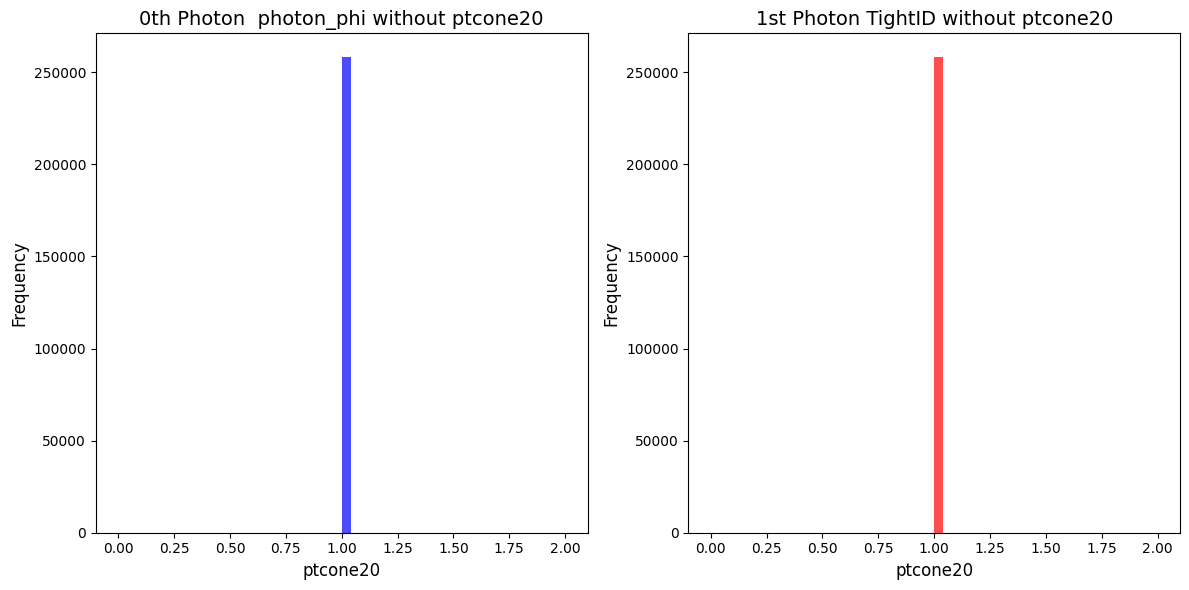

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import awkward as ak

# Assuming 'data' is your original DataFrame with 'photon_pt' as an Awkward Array

# Extract properties for the 0th and 1st photons
# Extracting the 0th and 1st photon properties directly during the list conversion
photon_pt_df = pd.DataFrame(data['photon_isTightID'].tolist())

# Use pandas' indexing to get the 0th and 1st photon pt columns efficiently
photon_pt0 = photon_pt_df.iloc[:, 0].dropna()  # 0th photon properties
photon_pt1 = photon_pt_df.iloc[:, 1].dropna()  # 1st photon properties


# Display the results
print("0th Photon Properties:", photon_pt0)
print("1st Photon Properties:", photon_pt1)

# You can also plot histograms for the 0th and 1st photon properties
plt.figure(figsize=(12, 6))

# Histogram for the 0th photon
plt.subplot(1, 2, 1)
plt.hist(photon_pt0, bins=50,range = (0,2) ,color='b', alpha=0.7)
plt.title('0th Photon  photon_phi without ptcone20', fontsize=14)
plt.xlabel('val', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Histogram for the 1st photon
plt.subplot(1, 2, 2)
plt.hist(photon_pt1, bins=50, range = (0,2), color='r', alpha=0.7)
plt.title('1st Photon TightID without ptcone20', fontsize=14)
plt.xlabel('val', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()
